# Loading and Visualizing scRNA-seq and scATAC-seq Data

In [1]:
import h5py
import hdf5plugin
import tables

import pandas as pd
import numpy as np
import scipy

import scanpy as sc
import anndata as ad

In [2]:
sc.set_figure_params(dpi=150)

In [3]:
base_dir = '/home/jovyan/kaggle/input/open-problems-multimodal/'
filenames = [
    'test_cite_inputs', 
    'test_multi_inputs', 
    'train_cite_inputs',
    'train_cite_targets',
    'train_multi_inputs',
    'train_multi_targets',
]

In [4]:
metadata_df = pd.read_csv('/home/jovyan/kaggle/input/open-problems-multimodal/metadata.csv')
metadata_df = metadata_df.set_index('cell_id')

The ATAC-seq data is stored in very large matrices (50,000-100,000 rows and over 220,000 columns). Although these matrices are very sparse, the .h5 format does not natively support sparse formats. We could load the ATAC-seq data into memory and then sparsify it, but this would take over 200GB of RAM. Instead we can load the dense ATAC-seq data in chunks, convert these chunks into a sparse format, then stack the chunks together.

The scRNA-seq data matrices are much less sparse (only 78% of entries are zero) so we don't load them in this way.

In [8]:
adatas = {}
chunk_size = 10000

for filename in filenames:
    print(f'loading {filename}.h5')
    filepath = base_dir + filename + '.h5'
    
    h5_file = h5py.File(filepath)
    h5_data = h5_file[filename]
    
    features = h5_data['axis0'][:]
    cell_ids = h5_data['axis1'][:]
    
    features = features.astype(str)
    cell_ids = cell_ids.astype(str)
    
    technology = metadata_df.loc[cell_ids, 'technology'].unique().item()
    
    if technology == 'multiome':
        sparse_chunks = []
        n_cells = h5_data['block0_values'].shape[0]
        
        for chunk_indices in np.array_split(np.arange(n_cells), 100):
            chunk = h5_data['block0_values'][chunk_indices]
            sparse_chunk = scipy.sparse.csr_matrix(chunk)
            sparse_chunks.append(sparse_chunk)
            
        X = scipy.sparse.vstack(sparse_chunks)
    elif technology == 'citeseq':
        X = h5_data['block0_values'][:]
        
    adata = ad.AnnData(
        X=X,
        obs=metadata_df.loc[cell_ids],
        var=pd.DataFrame(index=features),
    )
    
    adatas[filename] = adata

loading test_cite_inputs.h5
loading test_multi_inputs.h5
loading train_cite_inputs.h5
loading train_cite_targets.h5
loading train_multi_inputs.h5
loading train_multi_targets.h5


In [ ]:
adatas

{'test_cite_inputs': AnnData object with n_obs × n_vars = 48663 × 22050
     obs: 'day', 'donor', 'cell_type', 'technology',
 'test_multi_inputs': AnnData object with n_obs × n_vars = 55935 × 228942
     obs: 'day', 'donor', 'cell_type', 'technology',
 'train_cite_inputs': AnnData object with n_obs × n_vars = 70988 × 22050
     obs: 'day', 'donor', 'cell_type', 'technology',
 'train_cite_targets': AnnData object with n_obs × n_vars = 70988 × 140
     obs: 'day', 'donor', 'cell_type', 'technology',
 'train_multi_inputs': AnnData object with n_obs × n_vars = 105942 × 228942
     obs: 'day', 'donor', 'cell_type', 'technology',
 'train_multi_targets': AnnData object with n_obs × n_vars = 105942 × 23418
     obs: 'day', 'donor', 'cell_type', 'technology'}

## scATAC-seq Data

In [22]:
atac_adata = ad.concat([adatas['test_multi_inputs'], adatas['train_multi_inputs']])

In [25]:
sc.pp.pca(atac_adata, zero_center=None)

In [26]:
sc.pp.neighbors(atac_adata)

In [27]:
sc.tl.umap(atac_adata)

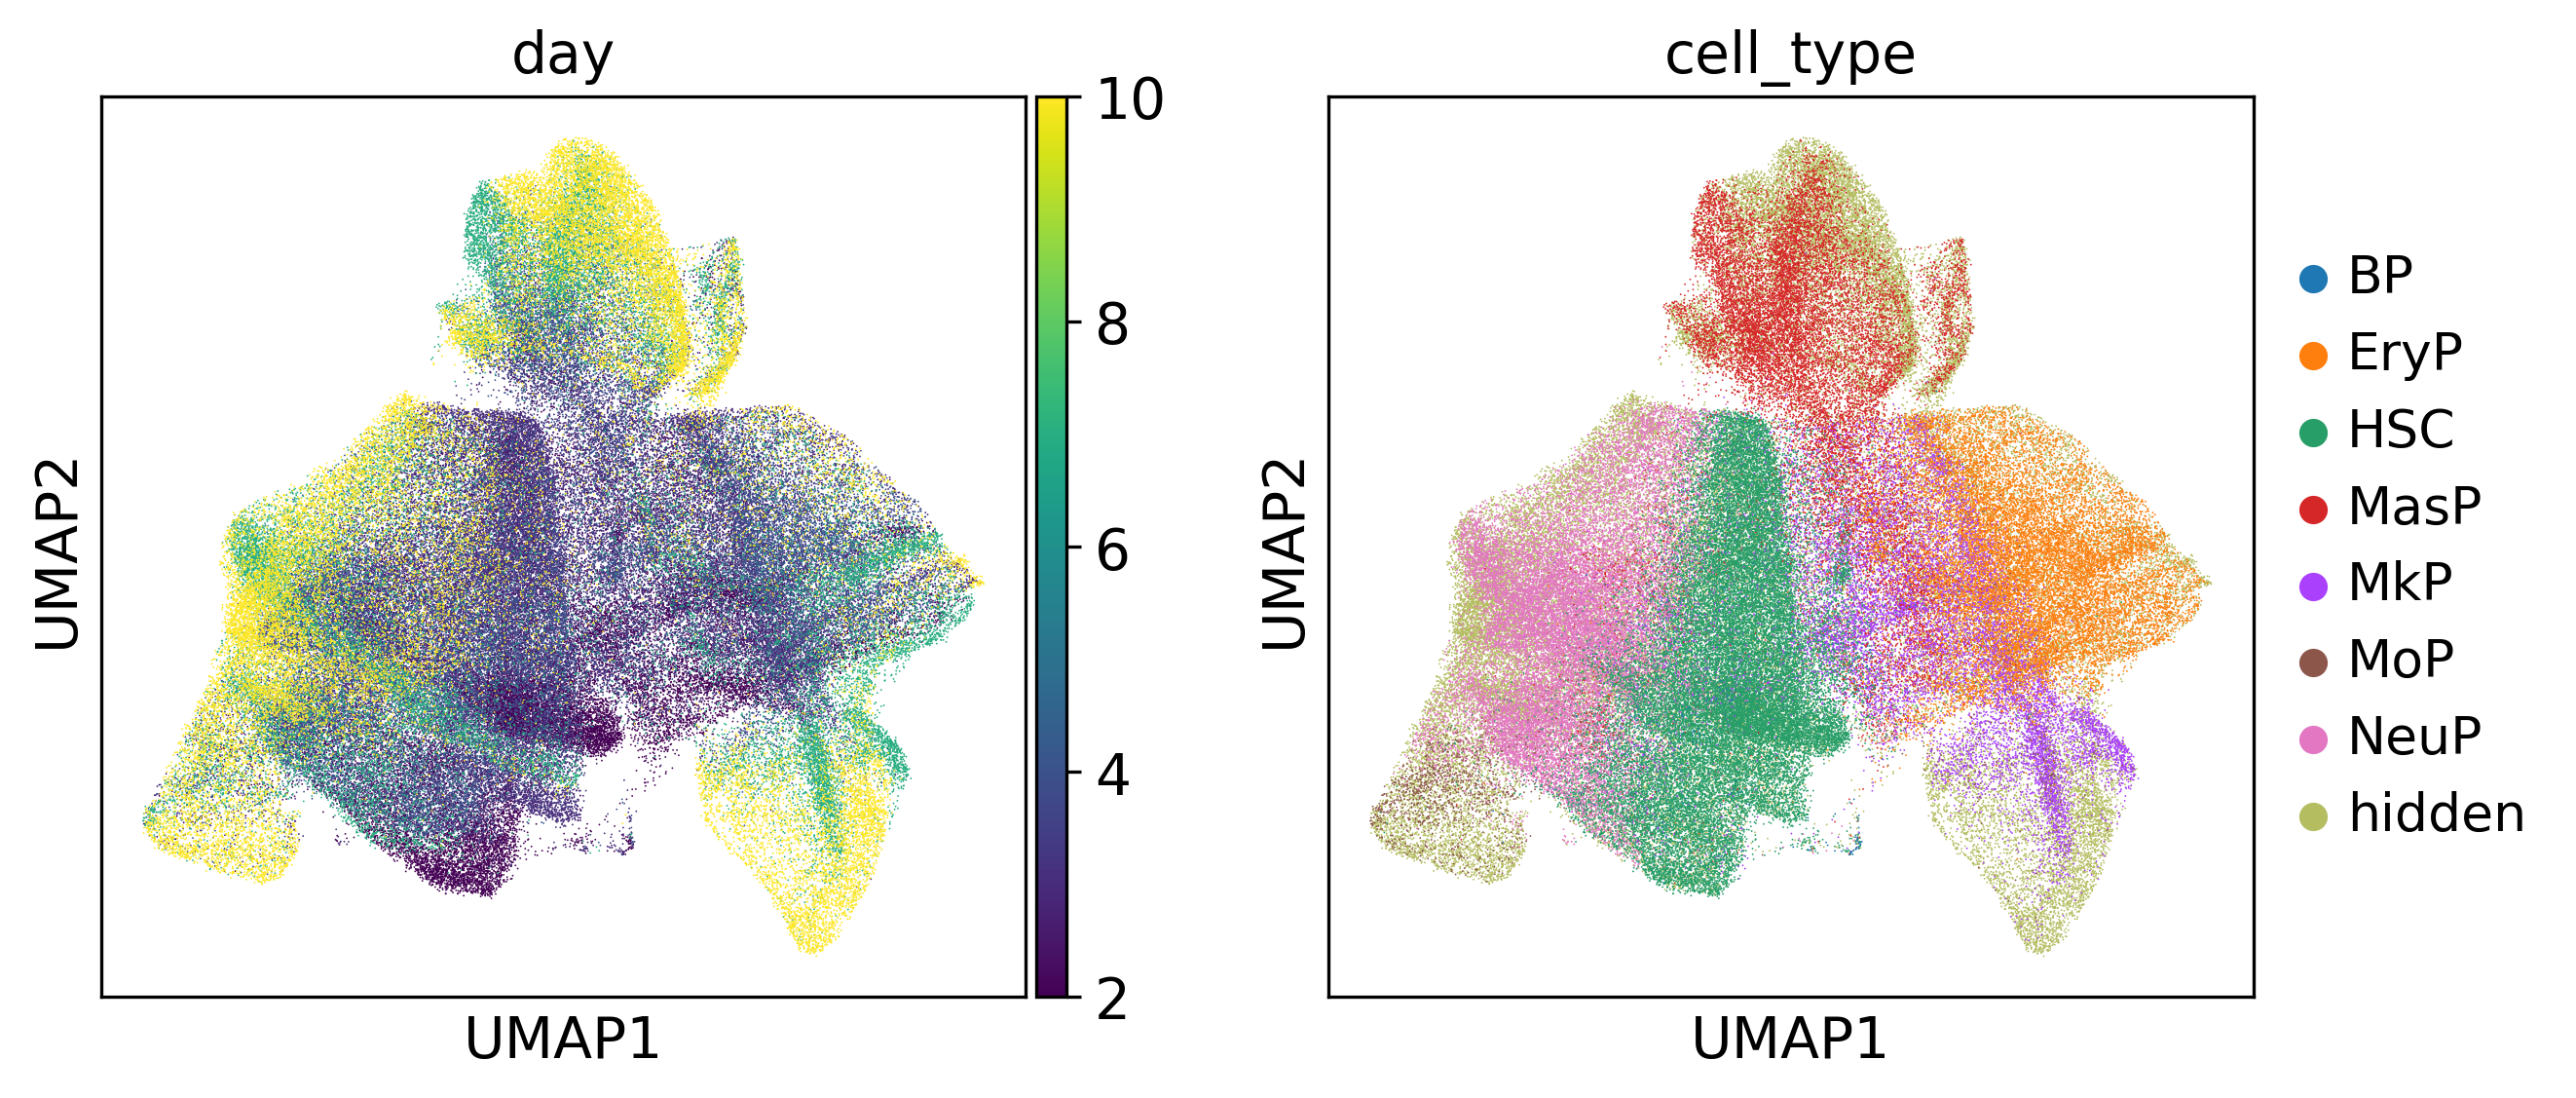

In [28]:
sc.pl.umap(atac_adata, color=['day', 'cell_type'])

## scRNA-seq Data

In [29]:
rna_adata = ad.concat([adatas['test_cite_inputs'], adatas['train_cite_inputs']])

In [30]:
sc.pp.pca(rna_adata)

In [31]:
sc.pp.neighbors(rna_adata)

In [32]:
sc.tl.umap(rna_adata)

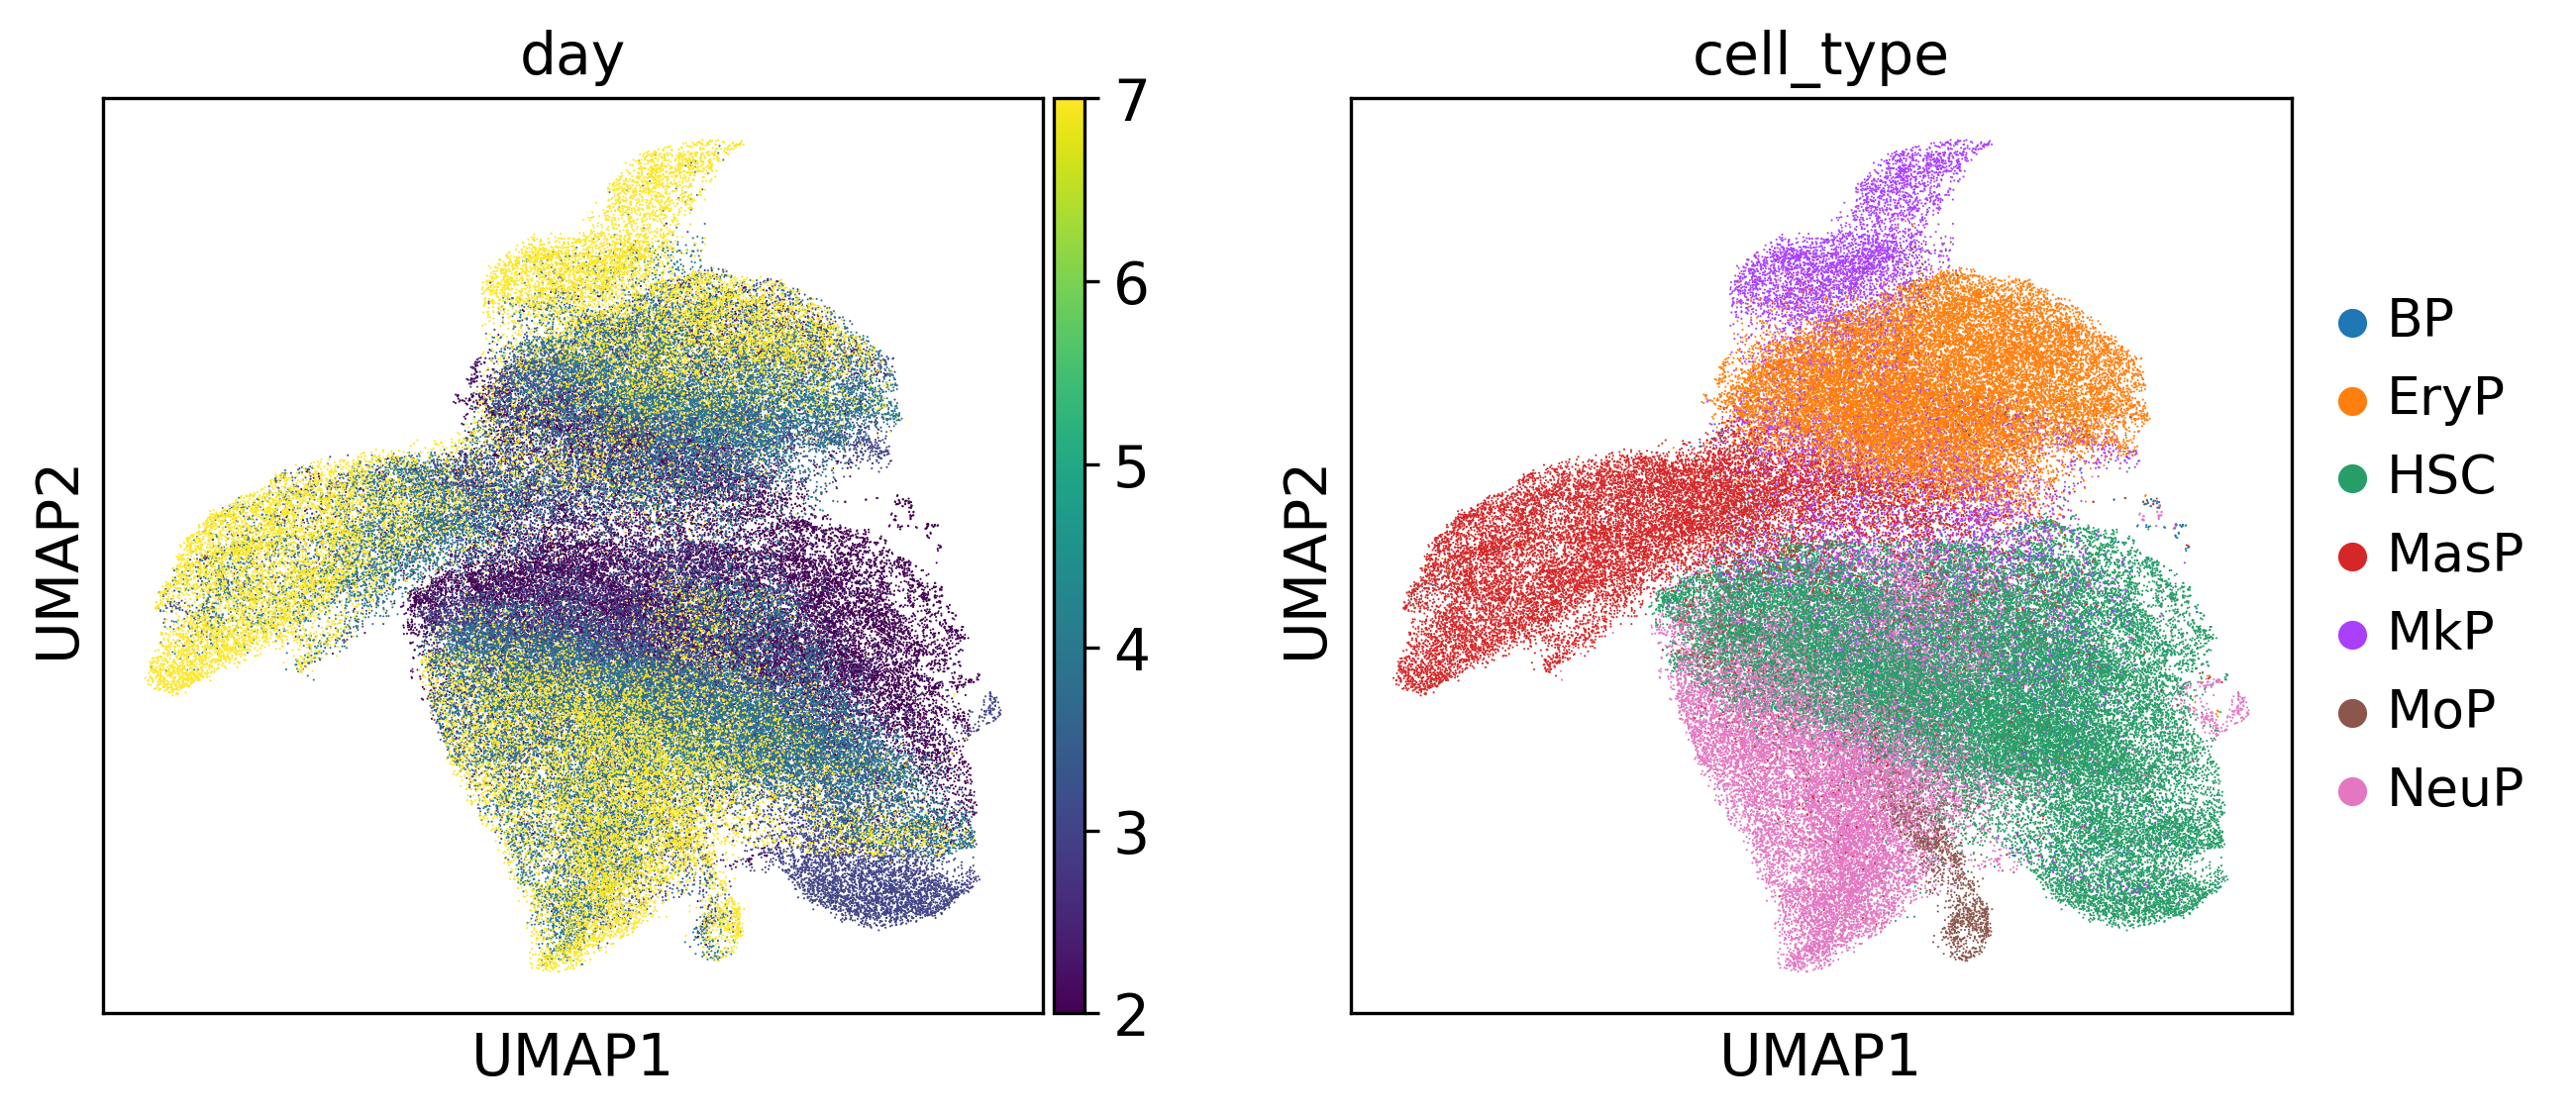

In [33]:
sc.pl.umap(rna_adata, color=['day', 'cell_type'])